##### Which aspect of a flight best predicts a customers' overall rating of an airline?

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# we open the file for reading
fileObject1 = open("df_air.pickle",'rb')
fileObject2 = open("df_main.pickle",'rb')
fileObject3 = open("star.pickle",'rb')
fileObject4 = open("budget.pickle",'rb')

# load the object from the file into variables
df_air = pickle.load(fileObject1)  
df = pickle.load(fileObject2) 
star = pickle.load(fileObject3) 
budget = pickle.load(fileObject4) 

In [3]:
df.head()

,airline_name,author_country,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommend,airline,cabin_class,overall
0,0,54,Outbound flight FRA/PRN A319. 2 hours 10 min f...,1,7.0,4.0,4.0,4.0,0.0,3.0,3.0,4.0,1,adria-airways,Economy,3.5
1,0,149,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,0,10.0,4.0,5.0,4.0,1.0,3.0,3.0,5.0,1,adria-airways,Business Class,5.0
2,0,138,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,1,9.0,5.0,5.0,4.0,0.0,3.0,3.0,5.0,1,adria-airways,Economy,4.5
3,0,129,Adria serves this 100 min flight from Ljubljan...,0,8.0,4.0,4.0,3.0,1.0,3.0,3.0,4.0,1,adria-airways,Business Class,4.0
4,0,118,WAW-SKJ Economy. No free snacks or drinks on t...,1,4.0,4.0,2.0,1.0,2.0,3.0,3.0,2.0,0,adria-airways,Economy,2.0


In [4]:
df.content

0        Outbound flight FRA/PRN A319. 2 hours 10 min f...
1        Two short hops ZRH-LJU and LJU-VIE. Very fast ...
2        Flew Zurich-Ljubljana on JP365 newish CRJ900. ...
3        Adria serves this 100 min flight from Ljubljan...
4        WAW-SKJ Economy. No free snacks or drinks on t...
5        Sarajevo-Frankfurt via Ljubljana. I loved flyi...
6        I had flights from Paris to Sarajevo via Ljubl...
7        LJU to FRA and back both flights were on time....
8        On my Ljubljana - Munich flight in business cl...
9        Flights from LJU to ZRH and back all on time. ...
10       I was very satisfied with the CRJ 900 on my fl...
11       I was on JP650 the evening departure to Istanb...
12       VIE-LJU LJU-MUC Aug 4-15th CRJ200. Both flight...
13       If I have to fly a regional jet then I prefer ...
14       Istanbul-Ljubljana-Munich and return. Pre-take...
15       Return flight Paris-Skopje via Ljubljana. All ...
16       BEG-LJU-BEG with CRJ200 great regional airline.

In [5]:
formula = 'overall ~ airline_name + author_country + seat_comfort_rating + cabin_staff_rating + food_beverages_rating + inflight_entertainment_rating + value_money_rating + cabin_flown + recommend'
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, train_size=.7)

##### ****** Lasso ******

In [7]:
###  Find best alpha using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)
print(optimal_lasso.alpha_)

###  Cross-validate the Lasso regression  R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_test, y_test, scoring='r2', cv=5)

print(lasso_scores)
print(np.mean(lasso_scores)) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0012568236339979236
[0.73487033 0.73388647 0.75796558 0.73946799 0.72690501]
0.7386190778385228


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [8]:
lasso.fit(X_train, y_train)
lasso.predict(X_test)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs

,variable,coef,abs_coef
9,recommend,0.812798,0.812798
7,value_money_rating,0.258895,0.258895
3,seat_comfort_rating,0.169488,0.169488
4,cabin_staff_rating,0.163820,0.163820
5,food_beverages_rating,0.051809,0.051809
2,author_country,0.033612,0.033612
1,airline_name,0.011770,0.011770
6,inflight_entertainment_rating,0.005502,0.005502
8,cabin_flown,-0.005298,0.005298
0,Intercept,0.000000,0.000000


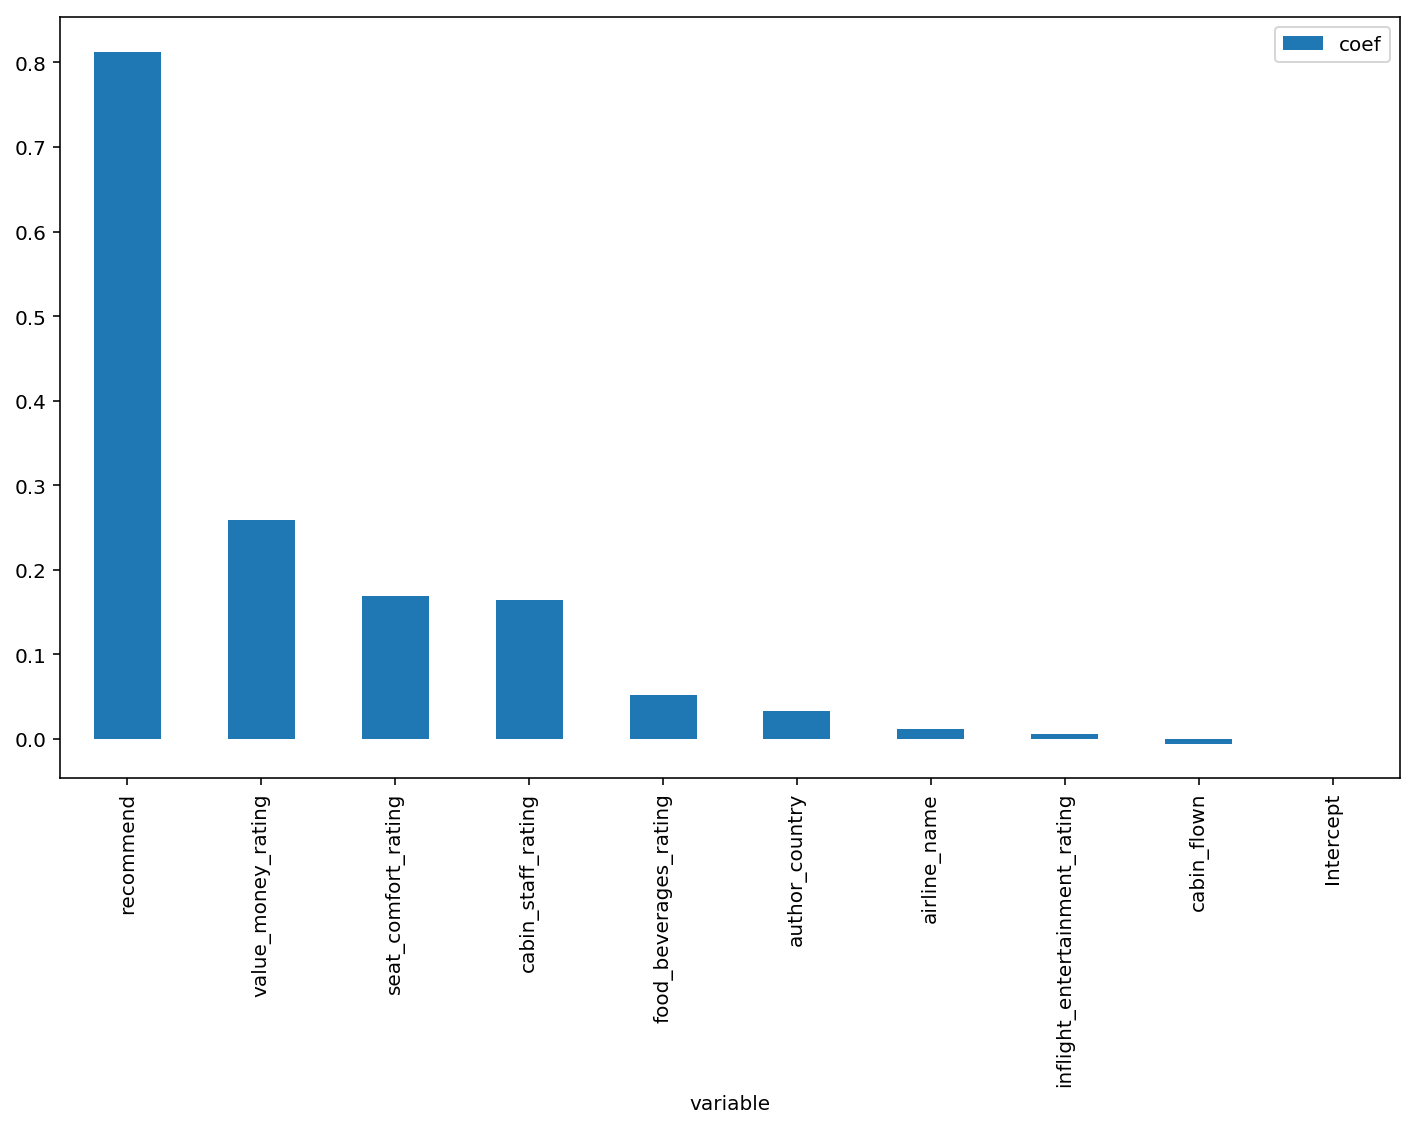

In [9]:
lasso_coefs.plot(kind='bar', x='variable', figsize=(12,7), y='coef')

##### ****  Use GridSearch on Lasso

In [10]:
lasso = Lasso()
parameters = {'alpha':[1e-04,2e-03,0.01,0.1,0.5,0.7,1,2,5], 
              'normalize':[True,False], 
              'tol':[1e-07,1e-06,2e-05,5e-05,1e-04,5e-04,2e-03,1e-02]}

gridsearch_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1)
gridsearch_lasso.fit(X_train, y_train)

print(gridsearch_lasso.best_score_)
print(gridsearch_lasso.best_estimator_.get_params())

y_pred_lasso1 = gridsearch_lasso.best_estimator_.predict(X_test).reshape(-1,1)

mse_lasso = mean_squared_error(y_test, y_pred_lasso1)
rmse_lasso = np.sqrt(mse_lasso)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7348016672392862
{'alpha': 0.0001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    3.6s finished


In [11]:
scores_lasso = cross_val_score(lasso, X_train, y_train, scoring='r2', cv=5)
print(scores_lasso)
print("Mean:", np.mean(scores_lasso), "Std:", np.std(scores_lasso))
print("RMSE:", rmse_lasso)

[0.24920817 0.25248457 0.25241348 0.24935414 0.24996846]
Mean: 0.25068576640339607 Std: 0.0014623109063111575
RMSE: 0.7764990610852339


##### ****** ElasticNet ******

In [12]:
###  Find best alpha and l1_ratio using ElasticNetCV
l1_ratios = np.linspace(0.01, 0.035, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=1, cv=5)
optimal_enet.fit(X_train, y_train)
print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_test, y_test, scoring='r2', cv=5)

print(enet_scores)
print(np.mean(enet_scores))

0.03590924668565496
0.035
[0.73418197 0.73376404 0.75727881 0.73897494 0.7262648 ]
0.7380929115929332


##### ****  Use Random Forest

In [13]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [14]:
print(cross_val_score(rf,X_test,y_test,cv=10,scoring='explained_variance', verbose=False).mean())

0.7652322222575282


In [15]:
rf_param={
    'criterion': ['mse'],
    'max_depth': [80],
    'max_features': ['auto'],
    'n_estimators': [1100,1200,1300],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,param_distributions=rf_param,n_iter=5,cv=8,verbose=2,random_state=5,n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:  2.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.8min finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'criterion': ['mse'], 'max_depth': [80], 'max_features': ['auto'], 'n_estimators': [1100, 1200, 1300], 'min_samples_leaf': [2], 'min_samples_split': [2]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

'explained_variance'
‘neg_mean_squared_error’
‘neg_mean_absolute_error’
‘neg_mean_squared_log_error’
‘neg_median_absolute_error’

In [16]:
print(rf_random.best_score_)
print(rf_random.best_params_)
model=rf_random.best_estimator_
print(cross_val_score(model,X_test,y_test,cv=8,scoring='explained_variance',verbose=False).mean())

0.7790225008728552
{'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'mse'}
0.7752411386272382


##### ****  Use RFECV for feature selection

In [17]:
# Use feature selection to identify relevant features
from sklearn.feature_selection import RFECV

rfe_lr = LinearRegression()
rfe1 = RFECV(rfe_lr, step=1, cv=10, n_jobs=-1, verbose=1)
rfe1.fit(X_train, y_train)

print('Number of features selected by RFE: {}'.format(rfe1.n_features_),'\n')
rfe1_list = X.columns[rfe1.support_]

print(rfe1_list,'\n')
print(rfe1.ranking_)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Number of features selected by RFE: 7 

Index(['airline_name', 'author_country', 'seat_comfort_rating',
       'cabin_staff_rating', 'food_beverages_rating', 'value_money_rating',
       'recommend'],
      dtype='object') 

[4 1 1 1 1 1 3 1 2 1]


##### ****  PCA with Stochastic Gradient Descent

In [18]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor

n_list=[x for x in range(1,11,1)]
score_list=[]
for n in range(1,11,1):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train2 = pca.transform(X_train)
    X_test2 = pca.transform(X_test)
    
    sgd_reg = SGDRegressor()
    selector = RFECV(sgd_reg, step=1, cv=5,scoring='r2')
    selector = selector.fit(X_train2, y_train)
    score_list.append(selector.score(X_test2,y_test))
    
print(np.array(score_list).max())
score_list.index(np.array(score_list).max())+1

0.7387523447674941


10

-----

### Which aspect of a flight best predicts if a customer would "recommend" the airline?

In [20]:
formula = 'recommend ~ airline + overall_rating + author_country + seat_comfort_rating + cabin_staff_rating + food_beverages_rating + inflight_entertainment_rating + ground_service_rating + wifi_connectivity_rating + value_money_rating + cabin_flown'
y = y.ravel()


In [22]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, train_size=.7)

##### ****  Use RFECV for feature selection

In [23]:
# Use feature selection to identify relevant features
from sklearn.feature_selection import RFECV

rfe_lr = LinearRegression()
rfe1 = RFECV(rfe_lr, step=1, cv=10, n_jobs=-1, verbose=1)
rfe1.fit(X_train, y_train)

print('Number of features selected by RFE: {}'.format(rfe1.n_features_),'\n')
rfe1_list = X.columns[rfe1.support_]

print(rfe1_list,'\n')
print(rfe1.ranking_)

Fitting estimator with 10 features.
Number of features selected by RFE: 9 

Index(['airline_name', 'author_country', 'seat_comfort_rating',
       'cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating', 'value_money_rating', 'cabin_flown',
       'recommend'],
      dtype='object') 

[2 1 1 1 1 1 1 1 1 1]


##### ****** Lasso ******

In [24]:
###  Find best alpha using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)
print(optimal_lasso.alpha_)

###  Cross-validate the Lasso regression  R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_test, y_test, cv=5)

print(lasso_scores)
print(np.mean(lasso_scores)) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0012619008193788187
[0.73153199 0.73572846 0.72738607 0.73370251 0.74899   ]
0.7354678058278067


In [25]:
lasso.fit(X_train, y_train)
lasso.predict(X_test)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [26]:
lasso_coefs

,variable,coef,abs_coef
9,recommend,0.824166,0.824166
7,value_money_rating,0.252877,0.252877
4,cabin_staff_rating,0.167568,0.167568
3,seat_comfort_rating,0.164360,0.164360
5,food_beverages_rating,0.043844,0.043844
2,author_country,0.035923,0.035923
1,airline_name,0.010370,0.010370
6,inflight_entertainment_rating,0.007912,0.007912
8,cabin_flown,-0.005826,0.005826
0,Intercept,0.000000,0.000000


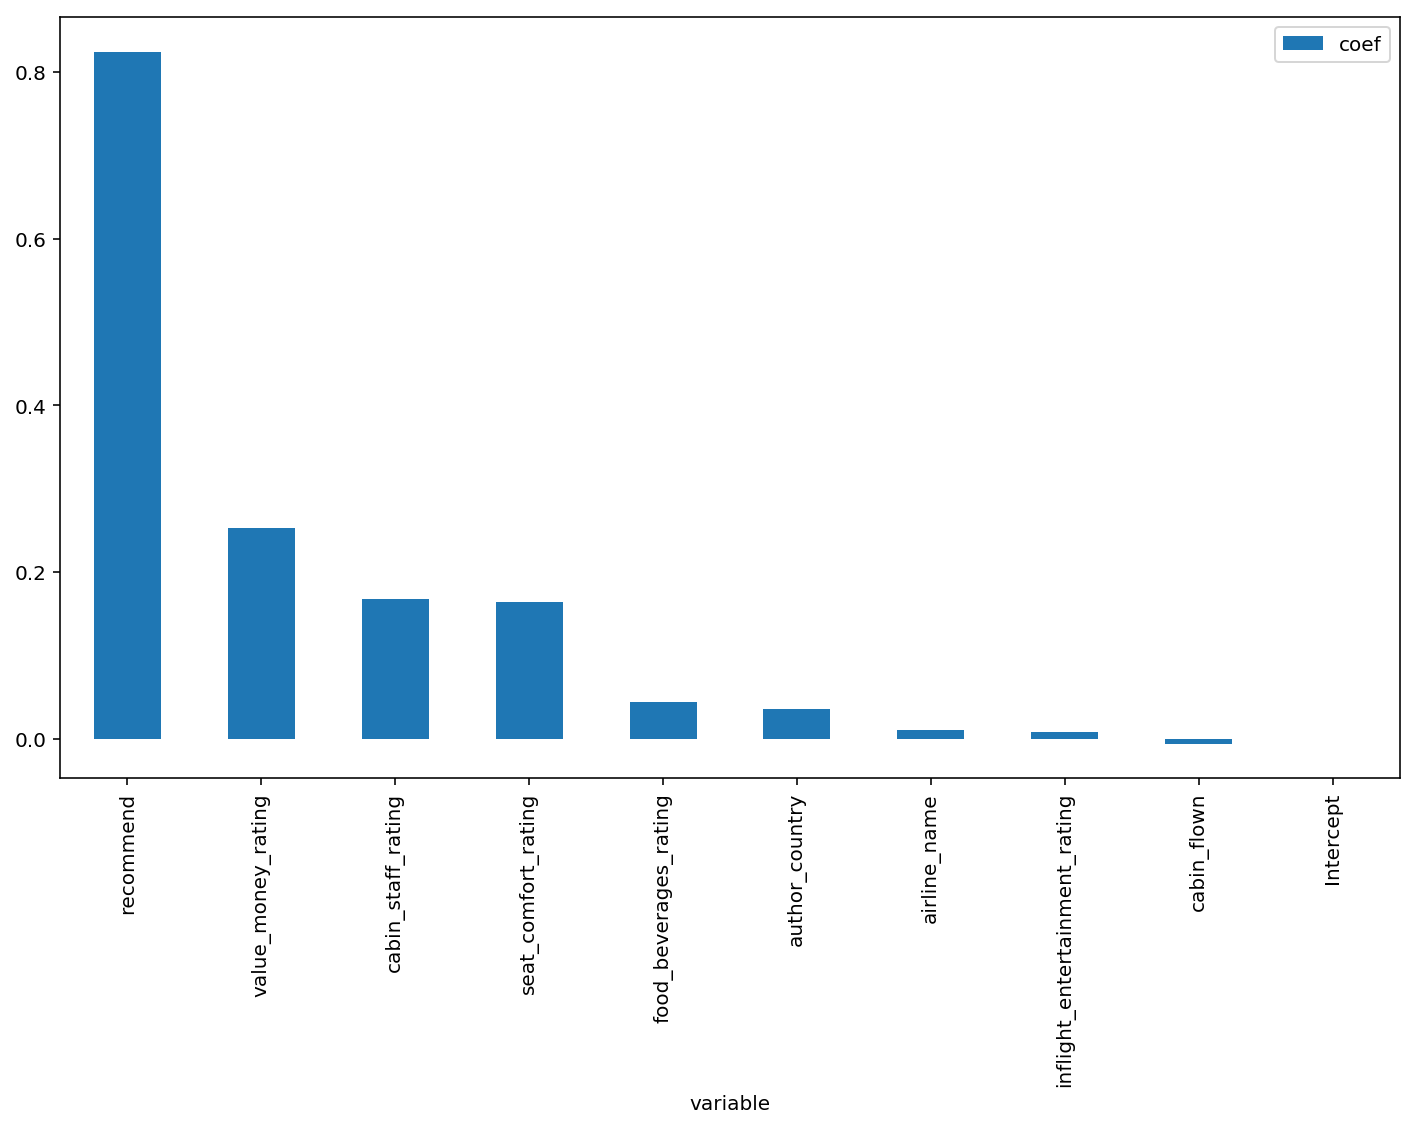

In [27]:
lasso_coefs.plot(kind='bar', x='variable', figsize=(12,7), y='coef')

In [28]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [29]:
print(cross_val_score(rf,X_test,y_test,cv=10,scoring='explained_variance',verbose=False).mean())

0.7633264089798526


In [30]:
rf_param={
    'criterion': ['mse'],
    'max_depth': [80],
    'max_features': ['auto'],
    'n_estimators': [1100,1200,1300],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,param_distributions=rf_param,n_iter=5,cv=8,verbose=2,random_state=5,n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:  2.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.8min finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'criterion': ['mse'], 'max_depth': [80], 'max_features': ['auto'], 'n_estimators': [1100, 1200, 1300], 'min_samples_leaf': [2], 'min_samples_split': [2]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [31]:
print(rf_random.best_score_)
print(rf_random.best_params_)
model=rf_random.best_estimator_

print(cross_val_score(model,X_test,y_test,cv=8,scoring='r2',verbose=False).mean())

0.7810246792301344
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'mse'}
0.7730839619645897


‘neg_mean_squared_error’
‘neg_mean_absolute_error’
‘neg_mean_squared_log_error’
‘neg_median_absolute_error’
‘r2’